In [ ]:
import os
import logging
import time
import argparse
import random
from datetime import timedelta

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Masking
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.interpolate import CubicSpline

logging.basicConfig(format="%(levelname)s %(message)s", level=logging.INFO)
MASK_VAL = -1.0


In [13]:
# GPU check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU device not found. Đảm bảo bạn đã chọn runtime GPU.")
else:
    print(f"Found GPU at: {device_name}")

Num GPUs Available:  1
Found GPU at: /device:GPU:0


I0000 00:00:1750752352.582209 1705809 gpu_device.cc:2019] Created device /device:GPU:0 with 22126 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [ ]:
def load_and_align_data(files: dict, variables: list, mask: float = MASK_VAL):
    idx = None
    # find common timestamps
    for path in files.values():
        df = pd.read_csv(path, parse_dates=["datetime"], index_col="datetime") \
            .fillna(mask)
        idx = df.index if idx is None else idx.intersection(df.index)

    data = []
    names = []
    for name, path in files.items():
        df = pd.read_csv(path, parse_dates=["datetime"], index_col="datetime") \
            .fillna(mask)
        for var in variables:
            if var in df.columns:
                data.append(df.loc[idx, var].values.tolist())
                names.append(f"{name}_{var}")
    return np.array(data), names, idx

def data_normalize(data):
    data = np.array(data)
    mask = data == MASK_VAL
    minv = np.min(data[~mask])
    maxv = np.max(data[~mask])
    norm = (data - minv) / (maxv - minv + 1e-8)
    norm[mask] = MASK_VAL
    return norm, (minv, maxv)

def data_denormalize(data, scale):
    minv, maxv = scale
    return data * (maxv - minv + 1e-8) + minv

In [15]:
def interpolate(data):
    data = np.array(data)
    filled = data.copy()
    for i in range(data.shape[0]):
        x = np.arange(data.shape[1])
        mask = data[i] != MASK_VAL
        if mask.sum() < 2:
            continue
        cs = CubicSpline(x[mask], data[i][mask])
        filled[i, ~mask] = cs(x[~mask])
    return filled

def create_sequences(X, Y, T_in, T_out, offset=0, stride=1):
    X = X.T  # (n_time, n_features)
    Y = Y.T  # (n_time, n_outputs)
    seq_X, seq_Y = [], []
    for start in range(offset, len(X) - T_in - T_out + 1, stride):
        end = start + T_in
        seq_X.append( X[start:end] )
        seq_Y.append( Y[end:end+T_out] )
    return np.array(seq_X), np.array(seq_Y)


In [ ]:
def stacked_LSTM(X, Y, learning_rate=6e-6):
    time_step = X.shape[1]
    input_dim = X.shape[2]
    out = Y.shape[2]
    T_out = Y.shape[1]

    start = time.time()
    model = Sequential()
    model.add(Masking(mask_value=MASK_VAL, input_shape=(time_step, input_dim)))
    model.add(Bidirectional(LSTM(64, activation='elu', return_sequences=True)))
    model.add(Bidirectional(LSTM(32, activation='elu', return_sequences=False)))
    model.add(Dense(T_out * out))
    model.add(tf.keras.layers.Reshape((T_out, out)))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    hist = model.fit(
        X, Y,
        epochs=50,
        validation_split=0.2,
        verbose=1,
        batch_size=10
    )
    model.summary()
    end = time.time()
    print("Total compile time: --------", end - start, 's')
    return model, hist

In [ ]:
def leave_one_sensor_out_pipeline(
    files: dict,
    variables: list,
    T_in: int = 335,
    T_out: int = 30,
    offset: int = 70,
    stride: int = 15,
    split_ratio: float = 0.8,
    learning_rate: float = 6e-6
    
):
    data, names, idx = load_and_align_data(files, variables)
    sensor_names = list(files.keys())
    n_sensor     = len(sensor_names)
    results      = {}

    for i in range(n_sensor):
        input_idx  = [j for j in range(n_sensor) if j != i]
        output_idx = i

        X_raw = data[input_idx, :]            # (n_sensor-1, time)
        Y_raw = data[output_idx, :].reshape(1, -1)  # (1, time)

        # normalize & interpolate
        X_norm, X_scale = data_normalize(X_raw)
        Y_norm, Y_scale = data_normalize(Y_raw)
        X_intp = interpolate(X_norm)
        Y_intp = interpolate(Y_norm)

        # sequences
        X_seq, Y_seq = create_sequences(
            X_intp, Y_intp, T_in, T_out, offset, stride
        )
    
        # split
        n_train = int(len(X_seq) * split_ratio)
        trX, teX = X_seq[:n_train], X_seq[n_train:]
        trY, teY = Y_seq[:n_train], Y_seq[n_train:]

        print(f"\n=== Predicting {sensor_names[output_idx]} " +
              f"using {[sensor_names[j] for j in input_idx]} ===")
        print(f"Train: X{trX.shape}, Y{trY.shape} | " +
              f"Test: X{teX.shape}, Y{teY.shape}")

        # train
        model, hist = stacked_LSTM(trX, trY, learning_rate=learning_rate)

        # predict & denorm
        preds = model.predict(teX, verbose=1)               # (n_samples, T_out, 1)
        preds = preds.squeeze(-1)                           # (n_samples, T_out)
        teY   = teY.squeeze(-1)                             # (n_samples, T_out)
        preds_denorm = data_denormalize(preds, Y_scale)     # (n_samples, T_out)
        teY_denorm   = data_denormalize(teY,   Y_scale)     # (n_samples, T_out)

        # flatten + mask NaN
        preds_flat = preds_denorm.flatten()
        true_flat  = teY_denorm.flatten()
        mask       = ~(np.isnan(preds_flat) | np.isnan(true_flat))

        preds_clean = preds_flat[mask]
        true_clean  = true_flat[mask]

        if preds_clean.size == 0:
            raise ValueError(
                f"All predictions for sensor {sensor_names[output_idx]} are NaN!"
            )

        # metrics
        mae  = mean_absolute_error(true_clean, preds_clean)
        # rmse = mean_squared_error(true_clean, preds_clean, squared=False)
        mse = mean_squared_error(true_clean, preds_clean)
        rmse = np.sqrt(mse)
        r2   = r2_score(true_clean, preds_clean)
        mape = mean_absolute_percentage_error(true_clean, preds_clean)

        print(f"Test MAE: {mae:.4f} | RMSE: {rmse:.4f} | " +
              f"R2: {r2:.4f} | MAPE: {mape:.2%}")

        results[sensor_names[output_idx]] = {
            "model":   model,
            "history": hist,
            "preds":   preds_clean,
            "true":    true_clean,
            "metrics": {
                "mae": mae,
                "rmse": rmse,
                "r2": r2,
                "mape": mape
            }
        }

        # plots
        plt.figure()
        plt.plot(hist.history["loss"], label="train loss")
        plt.plot(hist.history["val_loss"], label="val loss")
        plt.title(f"Loss for {sensor_names[output_idx]}")
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 4))
        plt.plot(true_clean, label="True")
        plt.plot(preds_clean, label="Pred")
        plt.title(f"Prediction for {sensor_names[output_idx]}")
        plt.legend()
        plt.show()

    return results


INFO Loaded 4 series with 117364 timesteps



=== Predicting sensor1 using ['sensor2', 'sensor3', 'sensor4'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)
Epoch 1/10


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - loss: 0.0364 - val_loss: 0.0091
Epoch 2/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 0.0126 - val_loss: 0.0067
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 0.0109 - val_loss: 0.0072
Epoch 4/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 0.0111 - val_loss: 0.0060
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - loss: 0.0111 - val_loss: 0.0072
Epoch 6/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - loss: 0.0107 - val_loss: 0.0069
Epoch 7/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 0.0103 - val_loss: 0.0060
Epoch 8/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 0.0101 - val_loss: 0.0070
Epoch 9/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 0.0105 - val_loss: 0.0094
Epoch 10/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 0.0108 - val_loss: 0.0083


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_12 (Masking)            │ (None, 335, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 335, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,572 (517.86 KB)

 Trainable params: 44,190 (172.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,382 (345.25 KB)

Total compile time: -------- 365.06705379486084 s
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
Test MAE: 1.4438 | RMSE: 2.3131 | R2: 0.9794 | MAPE: 7.27%


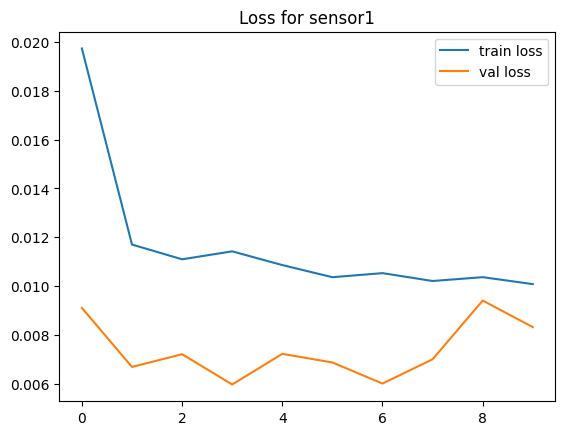

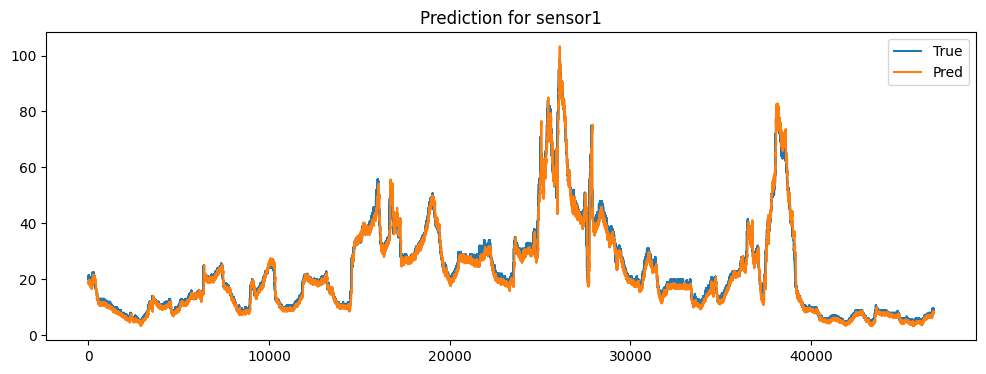


=== Predicting sensor2 using ['sensor1', 'sensor3', 'sensor4'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)
Epoch 1/10


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - loss: 0.0336 - val_loss: 0.0079
Epoch 2/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 0.0102 - val_loss: 0.0072
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - loss: 0.0096 - val_loss: 0.0065
Epoch 4/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - loss: 0.0093 - val_loss: 0.0064
Epoch 6/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - loss: 0.0091 - val_loss: 0.0068
Epoch 7/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - loss: 0.0088 - val_loss: 0.0073
Epoch 8/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - loss: 0.0091 - val_loss: 0.0067
Epoch 9/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - loss: 0.0085 - val_loss: 0.0065
Epoch 10/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 0.0091 - val_loss: 0.0061


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_13 (Masking)            │ (None, 335, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 335, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,572 (517.86 KB)

 Trainable params: 44,190 (172.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,382 (345.25 KB)

Total compile time: -------- 368.46432638168335 s
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Test MAE: 0.9355 | RMSE: 1.9336 | R2: 0.9748 | MAPE: 6.21%


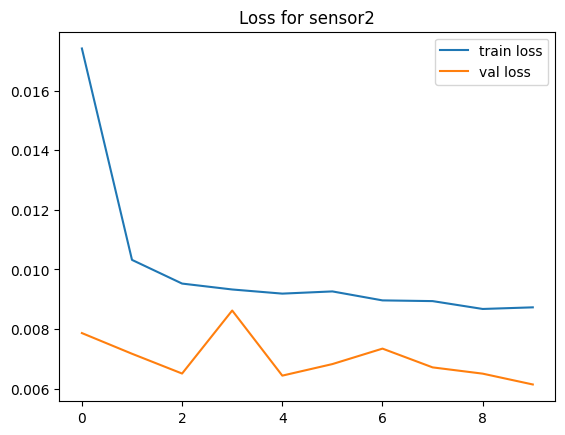

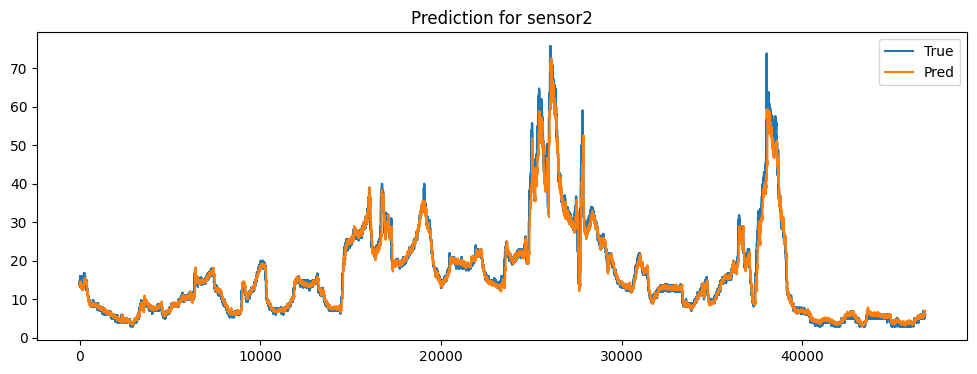


=== Predicting sensor3 using ['sensor1', 'sensor2', 'sensor4'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)
Epoch 1/10


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - loss: 0.0335 - val_loss: 0.0069
Epoch 2/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - loss: 0.0113 - val_loss: 0.0067
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - loss: 0.0104 - val_loss: 0.0066
Epoch 4/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - loss: 0.0105 - val_loss: 0.0065
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - loss: 0.0107 - val_loss: 0.0064
Epoch 6/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - loss: 0.0103 - val_loss: 0.0087
Epoch 7/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - loss: 0.0096 - val_loss: 0.0057
Epoch 8/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 9/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - loss: 0.0099 - val_loss: 0.0067
Epoch 10/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - loss: 0.0100 - val_loss: 0.0085


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_14 (Masking)            │ (None, 335, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 335, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,572 (517.86 KB)

 Trainable params: 44,190 (172.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,382 (345.25 KB)

Total compile time: -------- 358.12468361854553 s
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Test MAE: 1.8304 | RMSE: 2.8452 | R2: 0.9658 | MAPE: 8.57%


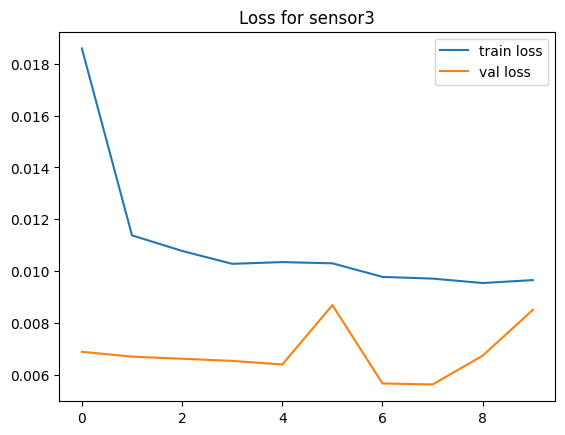

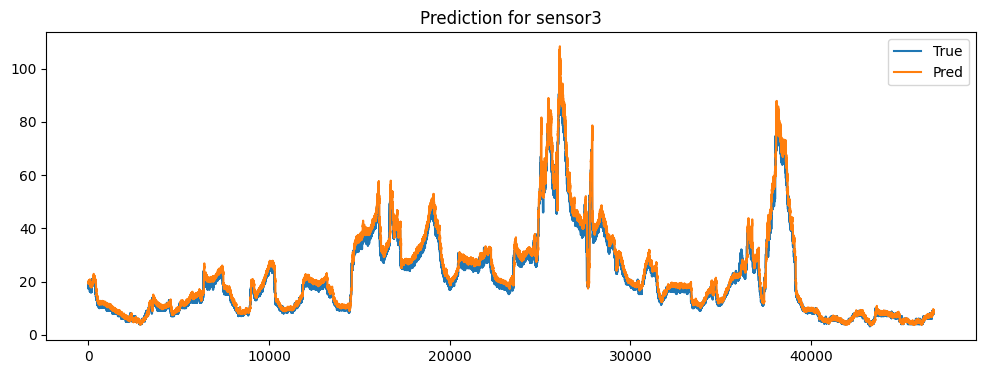


=== Predicting sensor4 using ['sensor1', 'sensor2', 'sensor3'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)
Epoch 1/10


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - loss: 0.0357 - val_loss: 0.0088
Epoch 2/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - loss: 0.0115 - val_loss: 0.0085
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - loss: 0.0116 - val_loss: 0.0079
Epoch 4/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - loss: 0.0103 - val_loss: 0.0072
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - loss: 0.0102 - val_loss: 0.0070
Epoch 6/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - loss: 0.0101 - val_loss: 0.0077
Epoch 7/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - loss: 0.0103 - val_loss: 0.0067
Epoch 8/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - loss: 0.0103 - val_loss: 0.0081
Epoch 9/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - loss: 0.0102 - val_loss: 0.0072
Epoch 10/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - loss: 0.0100 - val_loss: 0.0067


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_15 (Masking)            │ (None, 335, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 335, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_15 (Reshape)            │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,572 (517.86 KB)

 Trainable params: 44,190 (172.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,382 (345.25 KB)

Total compile time: -------- 370.4586434364319 s
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
Test MAE: 1.3221 | RMSE: 2.4292 | R2: 0.9734 | MAPE: 6.59%


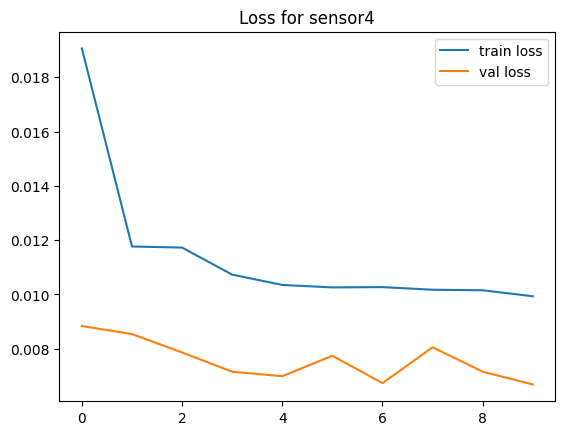

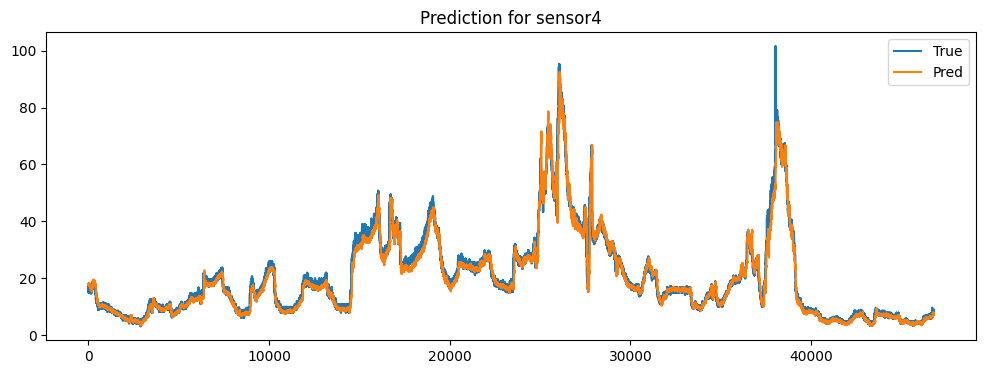

First sample — preds: [18.73089094 18.98609932 18.45017852 18.87864101 18.75087002 18.66430764
 18.36309077 18.37354498 18.40864764 18.58828571 18.54542948 18.77158553
 18.70252059 18.71408001 18.91213237 19.38381761 19.03183094 18.84111117
 18.86085082 18.87510521 19.32891175 18.52991667 19.2900157  19.49493086
 19.20457102 19.55145484 19.13961151 19.72955195 19.37563171 19.44968376]
First sample — truth: [20.  20.  20.  20.5 20.5 20.  20.  20.5 20.5 20.  20.5 21.  21.  20.5
 21.  21.5 21.  21.  21.  21.  21.  20.5 20.5 20.5 20.  20.  20.  20.
 20.  20. ]
Avg prediction (first sample): 17.33754595188749


: 

In [ ]:
if __name__ == "__main__":
    # hyper-params
    TRAIN_IN   = 335
    TEST_OUT   = 30
    PRED_GAP   = 70
    STRIDE     = 15
    SPLIT      = 0.8
    learning_rate = 6e-6

    variables = ["PM2_5.ug.m3."]
    base_dir  = "/home/nghia/Desktop/Minh_Workspace/V_IndoorCare/dataset/"
    files     = {
        f"sensor{i}": os.path.join(base_dir, f"{i:02d}_01mins.csv")
        for i in range(1, 5)
    }

    data, names, timeline = load_and_align_data(files, variables)
    logging.info(f"Loaded {data.shape[0]} series with {len(timeline)} timesteps")

    results = leave_one_sensor_out_pipeline(
        files=files,
        variables=variables,
        T_in=TRAIN_IN,
        T_out=TEST_OUT,
        offset=PRED_GAP,
        stride=STRIDE,
        split_ratio=SPLIT,
        learning_rate=learning_rate
    )

    # ví dụ: in window đầu tiên của sensor1
    preds1 = results["sensor1"]["preds"]
    true1  = results["sensor1"]["true"]
    print("First sample — preds:", preds1[:TEST_OUT])
    print("First sample — truth:", true1[:TEST_OUT])

    # trung bình across sensors
    all_preds = np.stack([r["preds"] for r in results.values()], axis=1)
    avg_pred  = all_preds.mean(axis=1)
    print("Avg prediction (first sample):", avg_pred[0])

INFO Loaded 4 series with 117364 timesteps



=== Predicting sensor1 using ['sensor2', 'sensor3', 'sensor4'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)
Epoch 1/5


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - loss: 0.0477 - val_loss: 0.0067
Epoch 2/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - loss: 0.0125 - val_loss: 0.0082
Epoch 3/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - loss: 0.0116 - val_loss: 0.0100
Epoch 4/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 0.0113 - val_loss: 0.0071
Epoch 5/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 0.0108 - val_loss: 0.0102


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_7 (Masking)             │ (None, 335, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 335, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,572 (517.86 KB)

 Trainable params: 44,190 (172.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,382 (345.25 KB)

Total compile time: -------- 184.6654758453369 s
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Test MAE: 1.8174 | RMSE: 2.8180 | R2: 0.9694 | MAPE: 8.25%


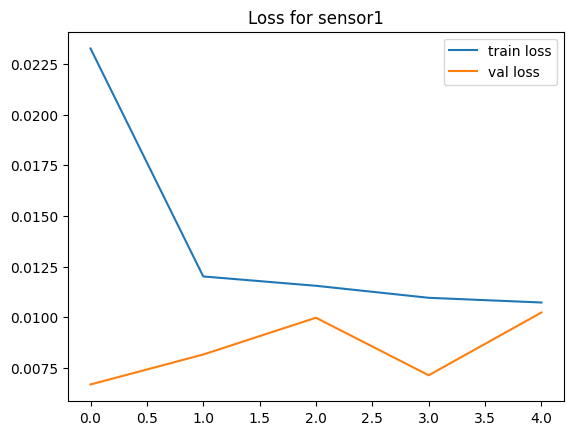

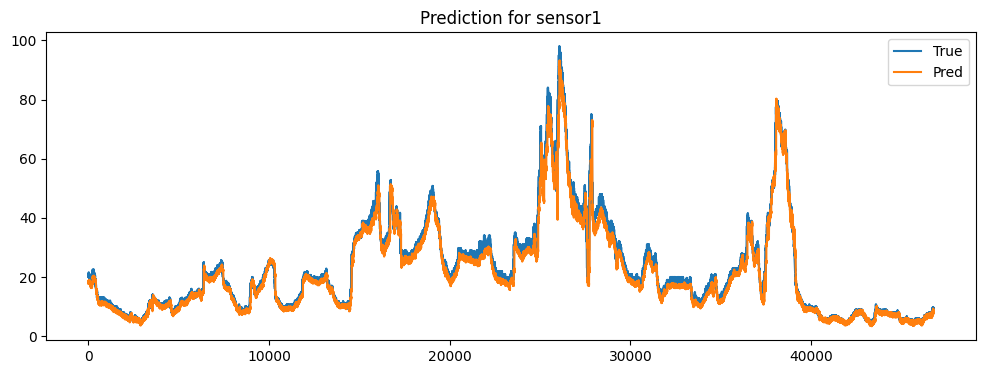


=== Predicting sensor2 using ['sensor1', 'sensor3', 'sensor4'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)
Epoch 1/5


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - loss: 0.0312 - val_loss: 0.0092
Epoch 2/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - loss: 0.0109 - val_loss: 0.0066
Epoch 3/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - loss: 0.0097 - val_loss: 0.0076
Epoch 4/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - loss: 0.0098 - val_loss: 0.0078
Epoch 5/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - loss: 0.0095 - val_loss: 0.0075


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_8 (Masking)             │ (None, 335, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 335, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,572 (517.86 KB)

 Trainable params: 44,190 (172.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,382 (345.25 KB)

Total compile time: -------- 189.68159556388855 s
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
Test MAE: 1.2720 | RMSE: 2.0790 | R2: 0.9708 | MAPE: 9.74%


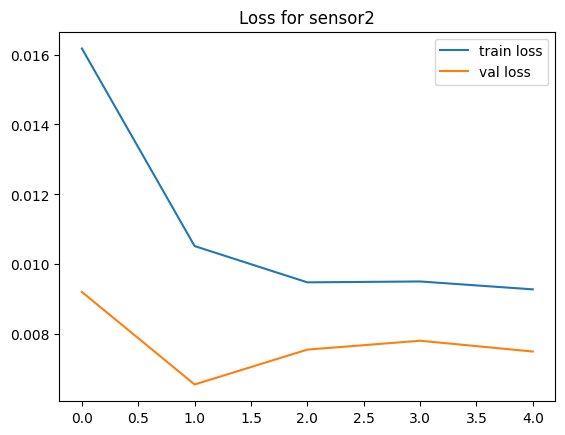

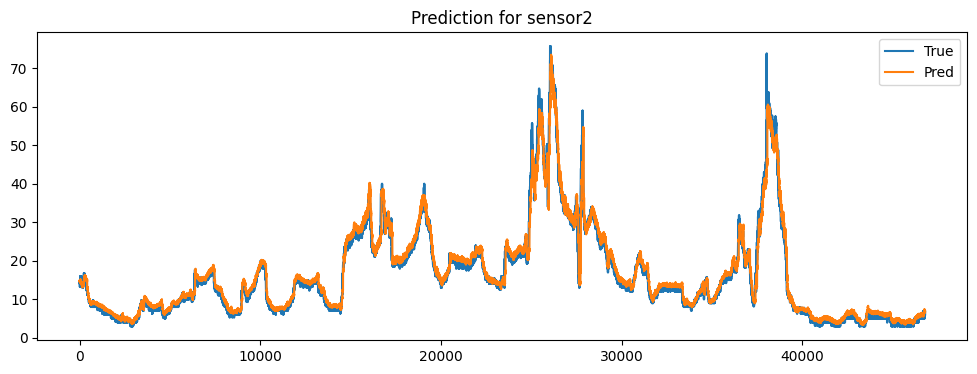


=== Predicting sensor3 using ['sensor1', 'sensor2', 'sensor4'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)
Epoch 1/5


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - loss: 0.0368 - val_loss: 0.0068
Epoch 2/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - loss: 0.0109 - val_loss: 0.0091
Epoch 3/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - loss: 0.0106 - val_loss: 0.0069
Epoch 4/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 0.0103 - val_loss: 0.0073
Epoch 5/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - loss: 0.0101 - val_loss: 0.0062


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_9 (Masking)             │ (None, 335, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 335, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,572 (517.86 KB)

 Trainable params: 44,190 (172.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,382 (345.25 KB)

Total compile time: -------- 184.9620714187622 s
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
Test MAE: 1.2849 | RMSE: 2.2619 | R2: 0.9784 | MAPE: 6.51%


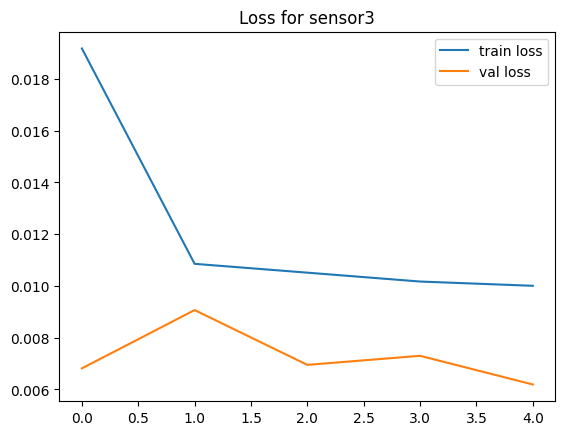

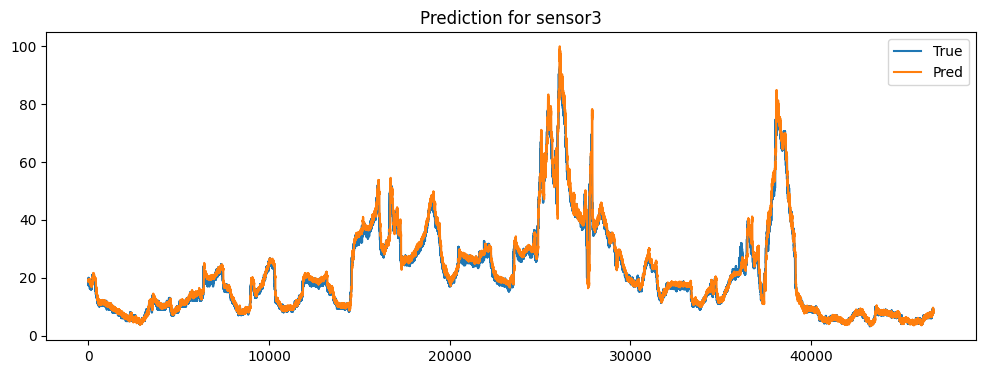


=== Predicting sensor4 using ['sensor1', 'sensor2', 'sensor3'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)
Epoch 1/5


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - loss: nan - val_loss: nan
Epoch 2/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - loss: nan - val_loss: nan
Epoch 3/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - loss: nan - val_loss: nan
Epoch 4/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - loss: nan - val_loss: nan
Epoch 5/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - loss: nan - val_loss: nan


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_10 (Masking)            │ (None, 335, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 335, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,572 (517.86 KB)

 Trainable params: 44,190 (172.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,382 (345.25 KB)

Total compile time: -------- 183.67847990989685 s
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


ValueError: All predictions for sensor sensor4 are NaN!

In [11]:
if __name__ == "__main__":
    # hyper-params
    TRAIN_IN   = 335
    TEST_OUT   = 30
    PRED_GAP   = 70
    STRIDE     = 15
    SPLIT      = 0.8

    variables = ["PM2_5.ug.m3."]
    base_dir  = "/home/nghia/Desktop/Minh_Workspace/V_IndoorCare/dataset/"
    files     = {
        f"sensor{i}": os.path.join(base_dir, f"{i:02d}_01mins.csv")
        for i in range(1, 5)
    }

    data, names, timeline = load_and_align_data(files, variables)
    logging.info(f"Loaded {data.shape[0]} series with {len(timeline)} timesteps")

    results = leave_one_sensor_out_pipeline(
        files=files,
        variables=variables,
        T_in=TRAIN_IN,
        T_out=TEST_OUT,
        offset=PRED_GAP,
        stride=STRIDE,
        split_ratio=SPLIT
    )

    # ví dụ: in window đầu tiên của sensor1
    preds1 = results["sensor1"]["preds"]
    true1  = results["sensor1"]["true"]
    print("First sample — preds:", preds1[:TEST_OUT])
    print("First sample — truth:", true1[:TEST_OUT])

    # trung bình across sensors
    all_preds = np.stack([r["preds"] for r in results.values()], axis=1)
    avg_pred  = all_preds.mean(axis=1)
    print("Avg prediction (first sample):", avg_pred[0])

INFO Loaded 4 series with 117364 timesteps



=== Predicting sensor1 using ['sensor2', 'sensor3', 'sensor4'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)
Epoch 1/5


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - loss: 0.0561 - val_loss: 0.0071
Epoch 2/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - loss: 0.0124 - val_loss: 0.0080
Epoch 3/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - loss: 0.0120 - val_loss: 0.0066
Epoch 4/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - loss: 0.0115 - val_loss: 0.0062
Epoch 5/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - loss: 0.0111 - val_loss: 0.0079


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 335, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 335, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,572 (517.86 KB)

 Trainable params: 44,190 (172.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,382 (345.25 KB)

Total compile time: -------- 185.71133422851562 s
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Test MAE: 1.5158 | RMSE: 2.6037 | R2: 0.9739 | MAPE: 6.53%


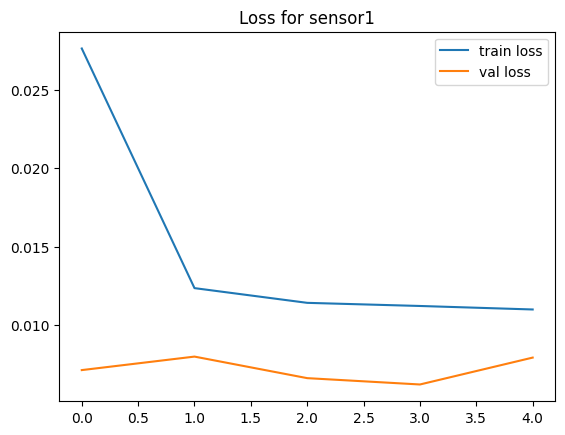

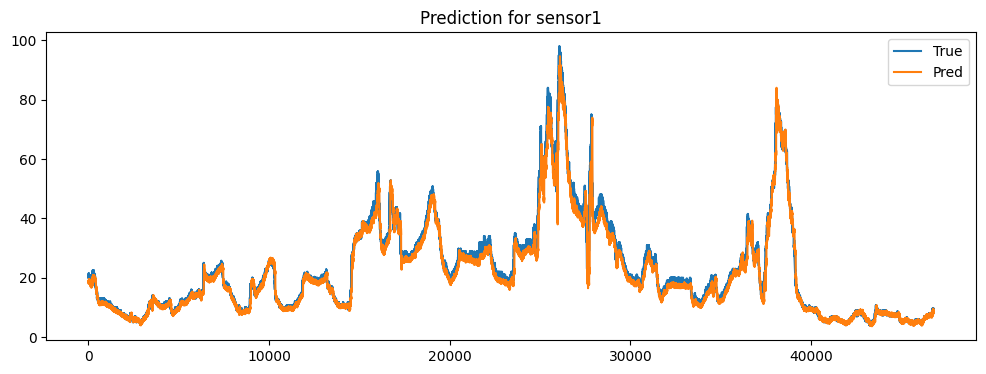


=== Predicting sensor2 using ['sensor1', 'sensor3', 'sensor4'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)
Epoch 1/5


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - loss: 0.0312 - val_loss: 0.0075
Epoch 2/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - loss: 0.0103 - val_loss: 0.0066
Epoch 3/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - loss: 0.0097 - val_loss: 0.0070
Epoch 4/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 5/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - loss: 0.0097 - val_loss: 0.0074


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 335, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 335, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,572 (517.86 KB)

 Trainable params: 44,190 (172.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,382 (345.25 KB)

Total compile time: -------- 184.6197474002838 s
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Test MAE: 1.0685 | RMSE: 2.1954 | R2: 0.9675 | MAPE: 6.44%


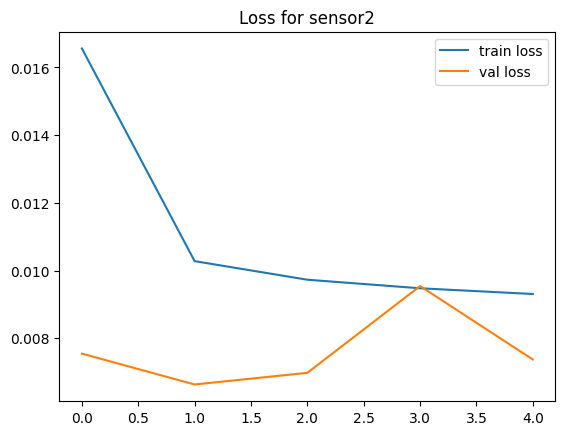

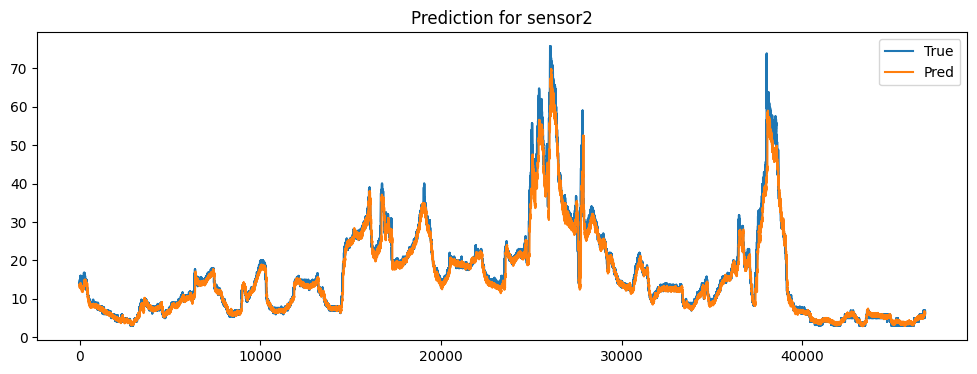


=== Predicting sensor3 using ['sensor1', 'sensor2', 'sensor4'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)
Epoch 1/5


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 44s 79ms/step - loss: nan - val_loss: nan
Epoch 2/5
 24/499 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - loss: nan

KeyboardInterrupt: 

In [8]:
if __name__ == "__main__":
    # hyper-params
    TRAIN_IN   = 335
    TEST_OUT   = 30
    PRED_GAP   = 70
    STRIDE     = 15
    SPLIT      = 0.8

    variables = ["PM2_5.ug.m3."]
    base_dir  = "/home/nghia/Desktop/Minh_Workspace/V_IndoorCare/dataset/"
    files     = {
        f"sensor{i}": os.path.join(base_dir, f"{i:02d}_01mins.csv")
        for i in range(1, 5)
    }

    data, names, timeline = load_and_align_data(files, variables)
    logging.info(f"Loaded {data.shape[0]} series with {len(timeline)} timesteps")

    results = leave_one_sensor_out_pipeline(
        files=files,
        variables=variables,
        T_in=TRAIN_IN,
        T_out=TEST_OUT,
        offset=PRED_GAP,
        stride=STRIDE,
        split_ratio=SPLIT
    )

    # ví dụ: in window đầu tiên của sensor1
    preds1 = results["sensor1"]["preds"]
    true1  = results["sensor1"]["true"]
    print("First sample — preds:", preds1[:TEST_OUT])
    print("First sample — truth:", true1[:TEST_OUT])

    # trung bình across sensors
    all_preds = np.stack([r["preds"] for r in results.values()], axis=1)
    avg_pred  = all_preds.mean(axis=1)
    print("Avg prediction (first sample):", avg_pred[0])

INFO Loaded 4 series with 117364 timesteps



=== Predicting sensor1 using ['sensor2', 'sensor3', 'sensor4'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1750663811.879779 1634777 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22126 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/5


I0000 00:00:1750663814.750111 1635028 service.cc:152] XLA service 0x26c23910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750663814.750129 1635028 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-06-23 16:30:14.802820: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750663815.095722 1635028 cuda_dnn.cc:529] Loaded cuDNN version 90501


  2/499 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - loss: 0.1192

I0000 00:00:1750663816.291513 1635028 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


499/499 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - loss: 0.0421 - val_loss: 0.0091
Epoch 2/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - loss: 0.0110 - val_loss: 0.0069
Epoch 3/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - loss: 0.0108 - val_loss: 0.0059
Epoch 4/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - loss: 0.0107 - val_loss: 0.0061
Epoch 5/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - loss: 0.0103 - val_loss: 0.0063


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 335, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,500 (130.86 KB)

 Trainable params: 11,166 (43.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,334 (87.25 KB)

Total compile time: -------- 126.89147877693176 s
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Test MAE: 1.3140 | RMSE: 2.3534 | R2: 0.9787 | MAPE: 6.43%


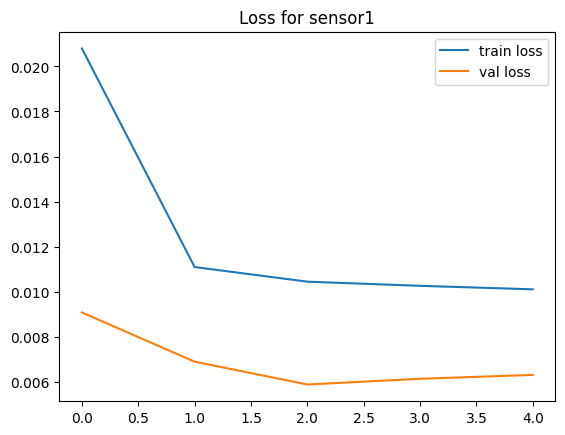

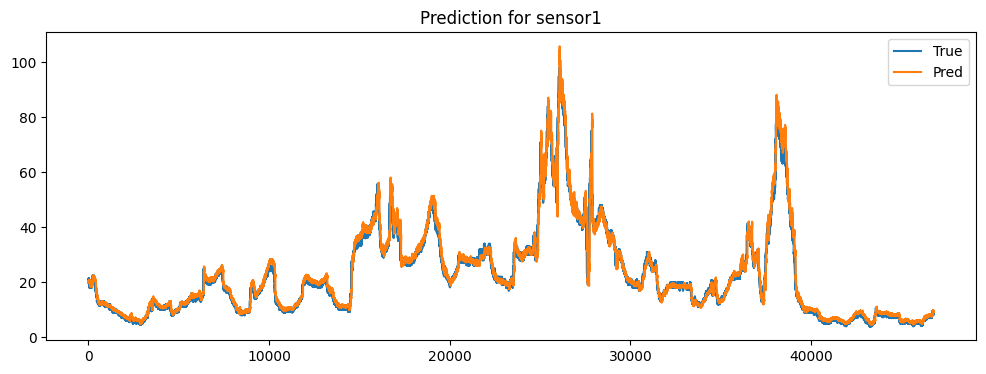


=== Predicting sensor2 using ['sensor1', 'sensor3', 'sensor4'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)
Epoch 1/5


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - loss: 0.0390 - val_loss: 0.0069
Epoch 2/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - loss: 0.0096 - val_loss: 0.0074
Epoch 3/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - loss: 0.0090 - val_loss: 0.0064
Epoch 4/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - loss: 0.0088 - val_loss: 0.0062
Epoch 5/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - loss: 0.0084 - val_loss: 0.0097


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 335, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,500 (130.86 KB)

 Trainable params: 11,166 (43.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,334 (87.25 KB)

Total compile time: -------- 122.16964411735535 s
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Test MAE: 1.2172 | RMSE: 2.2089 | R2: 0.9671 | MAPE: 7.84%


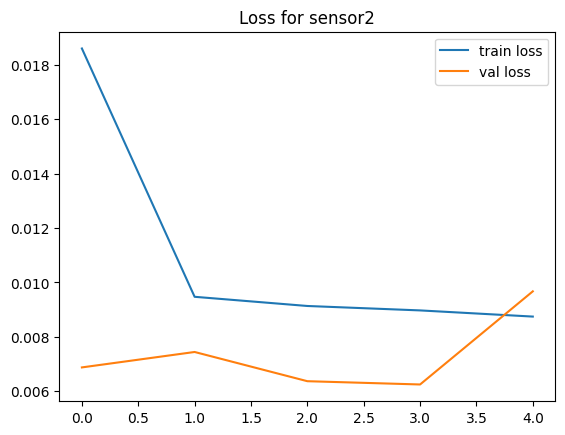

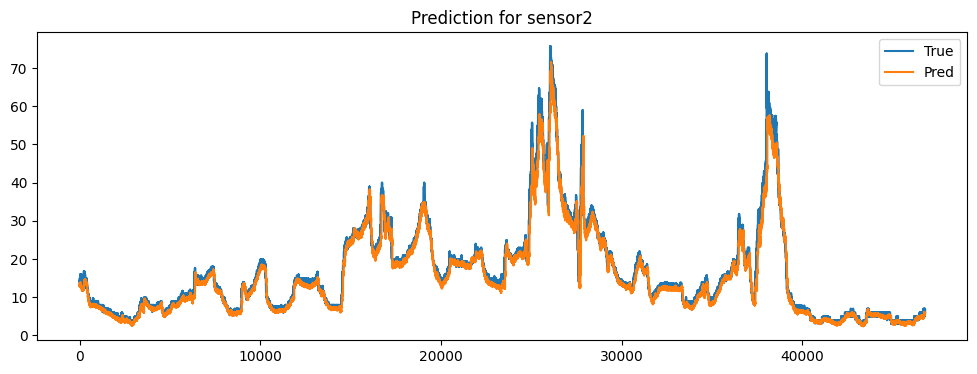


=== Predicting sensor3 using ['sensor1', 'sensor2', 'sensor4'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)
Epoch 1/5


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - loss: 0.0550 - val_loss: 0.0078
Epoch 2/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - loss: 0.0103 - val_loss: 0.0064
Epoch 3/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - loss: 0.0108 - val_loss: 0.0075
Epoch 4/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0102 - val_loss: 0.0069
Epoch 5/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0106 - val_loss: 0.0063


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 335, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,500 (130.86 KB)

 Trainable params: 11,166 (43.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,334 (87.25 KB)

Total compile time: -------- 118.93939304351807 s
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Test MAE: 1.2722 | RMSE: 2.3151 | R2: 0.9773 | MAPE: 6.39%


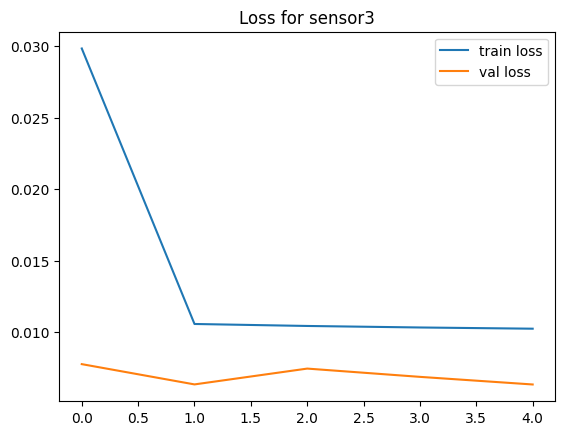

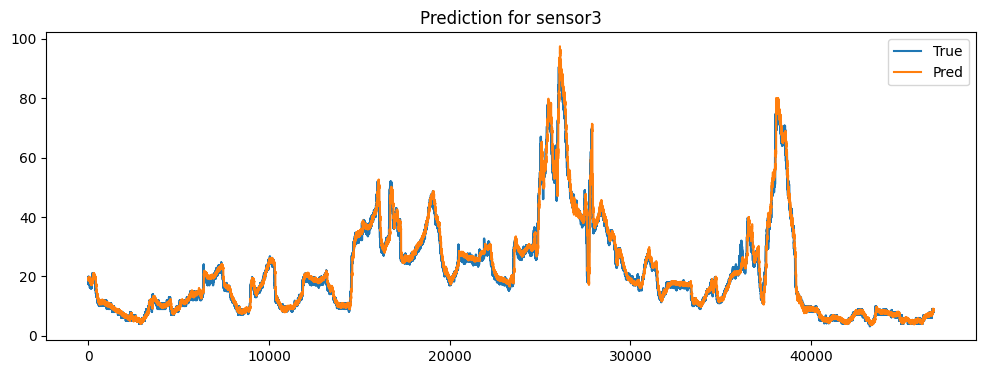


=== Predicting sensor4 using ['sensor1', 'sensor2', 'sensor3'] ===
Train: X(6236, 335, 3), Y(6236, 30, 1) | Test: X(1560, 335, 3), Y(1560, 30, 1)
Epoch 1/5


/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - loss: nan - val_loss: nan
Epoch 2/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - loss: nan - val_loss: nan
Epoch 3/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - loss: nan - val_loss: nan
Epoch 4/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - loss: nan - val_loss: nan
Epoch 5/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - loss: nan - val_loss: nan


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 335, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,500 (130.86 KB)

 Trainable params: 11,166 (43.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,334 (87.25 KB)

Total compile time: -------- 122.2277455329895 s
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


ValueError: All predictions for sensor sensor4 are NaN!

: 

In [ ]:
if __name__ == "__main__":
    # hyper-params
    TRAIN_IN   = 335
    TEST_OUT   = 30
    PRED_GAP   = 70
    STRIDE     = 15
    SPLIT      = 0.8

    variables = ["PM2_5.ug.m3."]
    base_dir  = "/home/nghia/Desktop/Minh_Workspace/V_IndoorCare/dataset/"
    files     = {
        f"sensor{i}": os.path.join(base_dir, f"{i:02d}_01mins.csv")
        for i in range(1, 5)
    }

    data, names, timeline = load_and_align_data(files, variables)
    logging.info(f"Loaded {data.shape[0]} series with {len(timeline)} timesteps")

    results = leave_one_sensor_out_pipeline(
        files=files,
        variables=variables,
        T_in=TRAIN_IN,
        T_out=TEST_OUT,
        offset=PRED_GAP,
        stride=STRIDE,
        split_ratio=SPLIT
    )

    # ví dụ: in window đầu tiên của sensor1
    preds1 = results["sensor1"]["preds"]
    true1  = results["sensor1"]["true"]
    print("First sample — preds:", preds1[:TEST_OUT])
    print("First sample — truth:", true1[:TEST_OUT])

    # trung bình across sensors
    all_preds = np.stack([r["preds"] for r in results.values()], axis=1)
    avg_pred  = all_preds.mean(axis=1)
    print("Avg prediction (first sample):", avg_pred[0])